In [19]:
import os
import glob
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import random
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt


C:\Users\Esteb\AppData\Local\Temp\ipykernel_16024\2005603844.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=device)


Modelo cargado desde simple_cnn_model.pkl
Precisión total: 92.29%


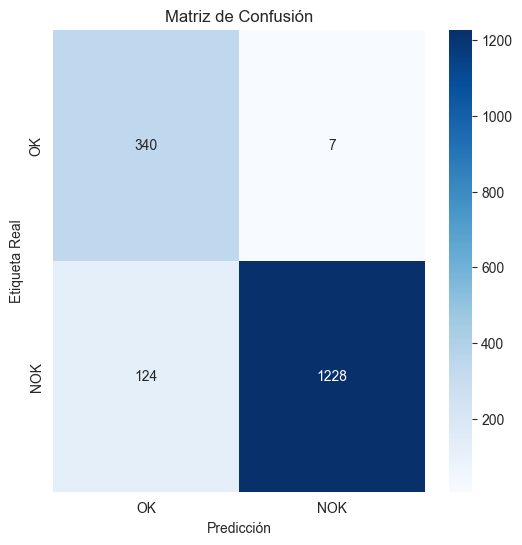

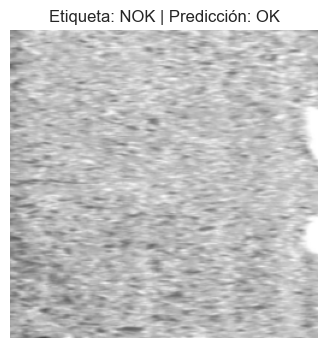

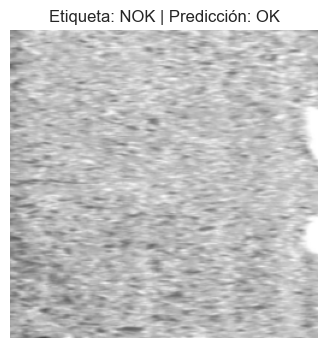

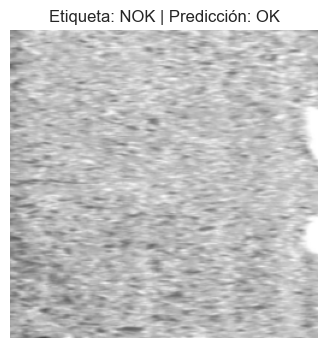

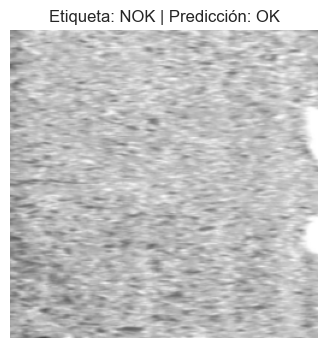

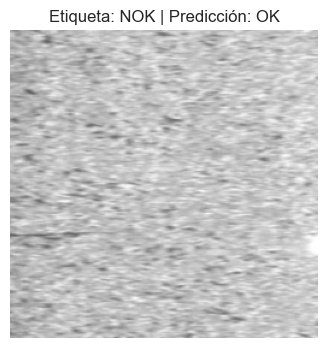

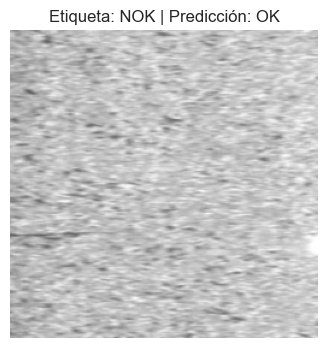

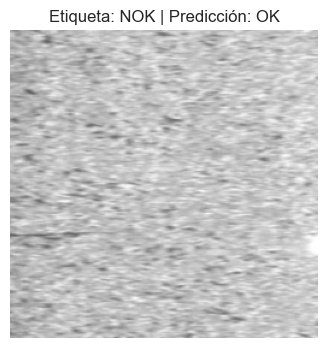

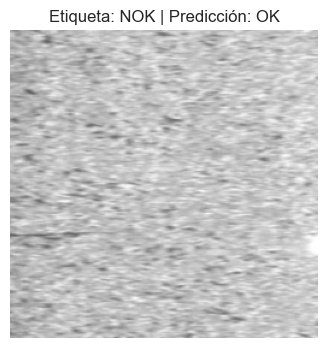

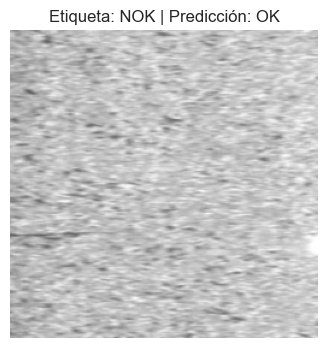

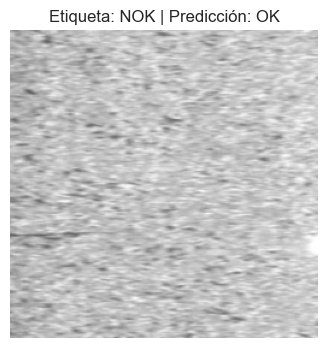

In [20]:
import os
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# ==================================================
# Dataset Personalizado
# ==================================================
class DefectDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self._load_data()

    def _load_data(self):
        for folder in sorted(os.listdir(self.root_dir)):
            folder_path = os.path.join(self.root_dir, folder)
            if not os.path.isdir(folder_path):
                continue

            images = sorted([f for f in os.listdir(folder_path) if f.endswith(".jpg")])
            masks = sorted([f for f in os.listdir(folder_path) if f.endswith("_label.bmp")])

            for img_name, mask_name in zip(images, masks):
                img_path = os.path.join(folder_path, img_name)
                mask_path = os.path.join(folder_path, mask_name)

                mask = Image.open(mask_path).convert("L")
                mask_array = torch.tensor(list(mask.getdata())).reshape(mask.size)
                label = 1 if mask_array.max() > 0 else 0
                self.data.append((img_path, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# ==================================================
# Modelo SimpleCNN
# ==================================================
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 64 * 64, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

# ==================================================
# Guardar y Cargar el Modelo
# ==================================================
def load_model(model, optimizer, path="model.pkl", device='cpu'):
    if os.path.exists(path):
        checkpoint = torch.load(path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print(f"Modelo cargado desde {path}")
    else:
        print(f"No se encontró el archivo {path}")
    return model, optimizer

# ==================================================
# Evaluación y Métricas
# ==================================================
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).float().view(-1, 1)
            outputs = model(images)
            predictions = (outputs > 0.5).float()
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    accuracy = 100 * correct / total
    print(f"Precisión total: {accuracy:.2f}%")

def evaluate_with_confusion_matrix(model, test_loader):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).float().view(-1, 1)
            outputs = model(images)
            predictions = (outputs > 0.5).float()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    cm = confusion_matrix(all_labels, all_predictions, labels=[0, 1])
    plot_confusion_matrix(cm, classes=['OK', 'NOK'])

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicción')
    plt.ylabel('Etiqueta Real')
    plt.title('Matriz de Confusión')
    plt.show()

def find_and_analyze_misclassified(model, test_loader, num_visualizations=10):
    model.eval()
    misclassified = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).float().view(-1, 1)
            outputs = model(images)
            predictions = (outputs > 0.5).float()

            for i in range(labels.size(0)):
                if predictions[i].item() != labels[i].item():
                    misclassified.append((images[i], labels[i].item(), predictions[i].item()))

    visualize_misclassified(misclassified, num_visualizations)

def visualize_misclassified(misclassified, num_visualizations):
    for i, (image, label, prediction) in enumerate(misclassified[:num_visualizations]):
        image = image.cpu().permute(1, 2, 0)
        image = image * 0.5 + 0.5
        plt.figure(figsize=(4, 4))
        plt.imshow(image.numpy())
        plt.title(f"Etiqueta: {'OK' if label == 0 else 'NOK'} | Predicción: {'OK' if prediction == 0 else 'NOK'}")
        plt.axis('off')
        plt.show()

# ==================================================
# Evaluar con Nuevos Datos
# ==================================================
def evaluate_with_new_data(model, new_data_dir, transform, batch_size=16):
    new_dataset = DefectDataset(root_dir=new_data_dir, transform=transform)
    new_loader = DataLoader(new_dataset, batch_size=batch_size, shuffle=False)
    test_model(model, new_loader)
    evaluate_with_confusion_matrix(model, new_loader)
    find_and_analyze_misclassified(model, new_loader, num_visualizations=10)

# ==================================================
# Configurar Nuevos Datos
# ==================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
new_data_dir = "./Imagenes_defectos3"  # Cambia esto a tu directorio de nuevos datos

# Cargar el modelo
new_model = SimpleCNN().to(device)
new_optimizer = torch.optim.Adam(new_model.parameters(), lr=0.001)
new_model, new_optimizer = load_model(new_model, new_optimizer, path="simple_cnn_model.pkl", device=device)

# Transformaciones para los nuevos datos
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# Evaluar el modelo con nuevos datos
evaluate_with_new_data(new_model, new_data_dir, transform=transform)

